### TODO
* Read all files into the list
* Check it out
* Choose files one by one
     * get info: platform, channels, business units
     * 

In [1]:
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy
import scipy.stats as stat
import xlsxwriter
from pathlib import Path

In [2]:
time_window_regr = 12 # number of weeks for regression

In [3]:
list_files = os.listdir("./input")
mypath = Path().absolute()
folder = 'output\\'
img_folder = folder + 'img\\'

In [4]:
# execute for all files
for i in list_files:
    pass

include image if regression available
add only new lines if it need (different numbers for raw with images and blank lines 

In [5]:
# Data type description for dataset columns
DateTimeID = ['periodStartDate']

usecols = [
    "account",
    "adCampaign", "platformCode","currencyCode", "channelCode", "marketingInvestment",
    "impressions", "clicks", "visits", "conversions", "deliveries",
    "netRevenue", "grossProfit", "adGroup", "periodStartDate","businessUnit"
          ]

dtype = {
    'account': str,
    'adCampaign' : str,
    'platformCode' : str,
    'businessUnit':str,
    'currencyCode':str,
    'channelCode' : str,
    'impressions' : int,
    'clicks' : int,
    'visits' : int,
    'conversions' : int,
    'deliveries' : int,
    'netRevenue' : float,
    'grossProfit' : float,
    'adGroup' : str,
    'marketingInvestment': float
}

In [6]:
# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    function = log_f # it's bad staff #TODO
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = function(t_train, *parameterTuple)
    return np.sum((y_train - val) ** 2.0)

In [7]:
def select_agg_resample_df(df, index, granularity, use_nan):
    """Function for select and group  data in dataframe
    input: pandas dataframe, name of index, granularity['week','month'] default as in dataframe
    return: aggregated dataframe with extra column with indexes [ROI, CPI, CPC]"""
    group_df = df.groupby(['periodStartDate']).agg({
    'netRevenue': 'sum',
    'marketingInvestment': 'sum', 
    'visits': 'sum', 
    'conversions': 'sum',
    'deliveries': 'sum', 
    'impressions': 'sum', 
    'clicks': 'sum', 
    'grossProfit': 'sum' })   

    if granularity == 'week':
        group_agg_df = group_df.resample('W-MON').agg('sum')
    elif granularity == 'month':
        group_agg_df = group_df.resample('M', convention='end').agg('sum')
    elif granularity == 'day':
        group_agg_df = group_df
    else:
        raise ValueError("Incorrect aggregation period, shuld be 'day', 'week' or 'month'")

    if use_nan == False:
        group_agg_df.fillna(0)
    else:
        pass
    return group_agg_df

In [8]:
# function for search initial value for regression parameters
from scipy.optimize import differential_evolution
import warnings
def generate_Initial_Parameters(t_train, y_train,function):
    # min and max used for bounds
    maxX = max(t_train)
    minX = min(t_train)
    maxY = max(y_train)
    minY = min(y_train)
    maxXY = max(maxX, maxY)

    parameterBounds = []
    parameterBounds.append([-maxXY, maxXY]) # seach bounds for a
    parameterBounds.append([-maxXY, maxXY]) # seach bounds for b
    #parameterBounds.append([-maxXY, maxXY]) # seach bounds for c

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

In [9]:
def regression_calc(df, function):
    """Calculate paramiters of regression function
    input: pandas dataframe [x,y]
    output: list[paramiters], list[std diviation err of paramiters]"""
    from scipy.optimize import curve_fit
    t_train = df[df.columns[0]]  #
    y_train = df[df.columns[1]]
    geneticParameters = generate_Initial_Parameters(t_train, y_train, log_f)
    popt, pcov = curve_fit(log_f, t_train, y_train, geneticParameters)
    #popt, pcov = curve_fit(function, t_train, y_train)
    error  = np.sqrt(np.diag(pcov))
    return popt, error

In [10]:
def filter_df(df, alpha):
    return df.ewm(alpha=alpha, adjust=False).mean()

In [35]:
# regression functions definition
def log_f(x, a, b):
    return a * (1-np.exp(-x/b)) #a * (1 - np.exp((x/b)))

def line_f(x, a, b):
    return a * x + b

def sine_f(x, a, b):
    return a * np.sin(b * x)

In [12]:
def save_chart(sorted_df, name, R_std):
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.subplots_adjust(bottom=0.15, left=0.2)
    x = np.linspace(0,sorted_df['marketingInvestment'].max(),20)
    ax.scatter(sorted_df['marketingInvestment'], sorted_df['grossProfit'])
    ax.plot(x,log_f(x, *regr)- 2*R_std)
    ax.plot(x,log_f(x, *regr)+ 2*R_std)
    ax.plot(x,log_f(x, *regr))
    ax.set_xlabel(f'Investment {name[1]}')
    ax.set_ylabel(f'Profit {name[1]}')
    ax.set_title(name[0])
    plt.savefig( name[0] + '.jpg', dpi=150, pad_inches=0.1)  
    plt.close()
    #plt.show()


In [13]:
list_files[4]

'audiopartner.csv'

In [14]:
df = pd.read_csv('input\\'+ list_files[4],
                 sep="\t",
                 infer_datetime_format=True,
                 usecols=usecols,
                 dtype=dtype,
                 parse_dates=DateTimeID)

df['periodStartDate'] = pd.to_datetime(df['periodStartDate'])

df.head(5)

,account,businessUnit,platformCode,channelCode,adCampaign,marketingInvestment,impressions,clicks,visits,conversions,deliveries,netRevenue,grossProfit,currencyCode,adGroup,periodStartDate
0,audiopartner,kytaryro,Compari,compari,NaN,0.00,0,0,63,2,1,20417.11,-1144.32,CZK,(not set),2020-01-21
1,audiopartner,kytaryro,unpaid,direct,NaN,0.00,0,0,0,10,9,58887.13,14298.72,CZK,(not set),2020-01-21
2,audiopartner,kytaryro,AdWords,googleadsdsother,NaN,0.00,0,0,2,0,0,0.00,0.00,CZK,(not set),2020-01-21
3,audiopartner,kytaryro,unpaid,organic,NaN,0.00,0,0,0,5,5,5961.50,735.00,CZK,(not set),2020-01-21
4,audiopartner,kytaryro,Compari,compari,-,198.18,0,106,0,0,0,0.00,0.00,CZK,NaN,2020-01-21


In [15]:
df.shape

(580441, 16)

In [16]:
#list_files[6]

In [17]:
platform_code = df['platformCode'].unique().tolist()
platform_code.sort()
business_unit_code = df['businessUnit'].unique().tolist()
business_unit_code.sort()
channel_code_code = df['channelCode'].unique().tolist()
channel_code_code.sort()
currency_code_code = df['currencyCode'].unique().tolist()
currency_code_code.sort()
account_code = df['account'].unique().tolist()

In [18]:
account_code

['audiopartner']

In [19]:
df['periodStartDate'].min()

Timestamp('2020-01-21 00:00:00')

In [20]:
df['periodStartDate'].max()

Timestamp('2021-01-18 00:00:00')

In [21]:
#select window for regression 
excel_coll = 0
precision = 3

workbook = xlsxwriter.Workbook( 'campaign_' + account_code[0]+'_corr.xlsx') #folder + 
bold = workbook.add_format({'bold': True})


df_time_selected = df[df['periodStartDate'] >= df['periodStartDate'].max() - pd.DateOffset(weeks=time_window_regr)] 

#df_time_selected = filter_df(df_time_selected, 0.1)

for i in business_unit_code:
    df_selected = df_time_selected[df_time_selected['businessUnit'] == i]
    worksheet = workbook.add_worksheet(i)
    
    worksheet.set_column('A:A', 30)
    worksheet.set_column('B:B', 10)
    worksheet.set_column('C:C', 15)
    worksheet.set_column('D:D', 15)
    worksheet.set_column('E:E', 15)
    worksheet.set_column('F:F', 15)
    worksheet.set_column('G:G', 40)

    worksheet.write('A1', 'Name', bold)
    worksheet.write('B1', 'Corr coeff.', bold)
    worksheet.write('C1', 'a', bold)
    worksheet.write('D1', 'b', bold)
    worksheet.write('E1', 'c', bold)
    worksheet.write('F1', 'R-std', bold)
    worksheet.write('G1', 'Chart', bold)
    
    excel_row  = 2
    
    for z in platform_code:
        df_platform = df_selected[df_selected['platformCode'] == z]
        df_business_selected_agg = select_agg_resample_df(df_platform, 'periodStartDate', 'week', use_nan = False)
        df_business_selected_agg = filter_df(df_business_selected_agg, 0.05)
        sper_crr, _=stat.spearmanr(df_business_selected_agg['marketingInvestment'], df_business_selected_agg['grossProfit'])
        if sper_crr> 0.75:
            print (i + ' business unit '+ z + ' platform has \t'+ str(sper_crr) + ' correlation coefficient')

            try:
                sorted_df = df_business_selected_agg.sort_values( by=['marketingInvestment'], ascending=False )
                t_train = sorted_df['marketingInvestment']
                y_train = sorted_df['grossProfit']
                
                regr, err = regression_calc(sorted_df[['marketingInvestment','grossProfit']],log_f)
                
                R = sorted_df['grossProfit'] - log_f(sorted_df['marketingInvestment'], *regr)
                R_std = R.describe()['std']
                
                ing_name = [i+z, currency_code_code]
                save_chart(sorted_df, ing_name, R_std)
                             
                a,b = regr
                #print(a,b,c)
                worksheet.write('A'+str(excel_row), z)
                worksheet.write('B'+str(excel_row), str(np.round(sper_crr, precision)))
                
                worksheet.write('C'+str(excel_row), str(np.round(a, precision)))
                worksheet.write('D'+str(excel_row), str(np.round(b, precision)))
                #worksheet.write('E'+str(excel_row), str(np.round(c, precision)))
                
                
                worksheet.write('F'+str(excel_row), str(np.round(R_std, precision)))
                
                worksheet.insert_image('G'+ str(excel_row), i + z + '.jpg', {'x_scale': 0.5, 'y_scale': 0.5})
                
                excel_row = excel_row + 10
                print('Regression calculated successfully')
            except:
                print("Regression wasn't calculated")
                worksheet.write('A'+ str(excel_row), z)
                excel_row = excel_row + 1

        else:
            pass

workbook.close()

kytaryat business unit AdWords platform has 	1.0 correlation coefficient
Regression calculated successfully
kytarycz business unit AdWords platform has 	1.0 correlation coefficient
Regression calculated successfully
kytarycz business unit DogNet platform has 	0.9945054945054945 correlation coefficient
Regression calculated successfully
kytarycz business unit FacebookBusinessAdsManager platform has 	0.9583102199603798 correlation coefficient
Regression calculated successfully
kytarycz business unit HeurekaCz platform has 	0.9065934065934067 correlation coefficient
Regression calculated successfully
kytarycz business unit Sklik platform has 	0.9780219780219779 correlation coefficient
Regression calculated successfully
kytarycz business unit ZboziCz platform has 	1.0 correlation coefficient
Regression calculated successfully
kytaryde business unit AdWords platform has 	0.989010989010989 correlation coefficient
Regression calculated successfully
kytaryde business unit Idealo platform has 	

In [22]:
sper_corr, _ = stat.spearmanr(df_business_selected_agg['marketingInvestment'], df_business_selected_agg['grossProfit'])

In [23]:
df_time_selected = df[df['periodStartDate'] >= df['periodStartDate'].max() - pd.DateOffset(weeks=time_window_regr)] 

df_business_selected = df_time_selected[df_time_selected['businessUnit'] == 'forhomecz']

df_business_selected = df_business_selected[df_business_selected['platformCode'] == 'AdWords']

df_business_selected_agg = select_agg_resample_df(df_business_selected, 'periodStartDate', 'week', use_nan = False)

df_business_selected_agg_filtered = filter_df(df_business_selected_agg, 0.01)

sorted_df = df_business_selected_agg_filtered.sort_values( by=['marketingInvestment'], ascending=False )

t_train = sorted_df['marketingInvestment']

y_train = sorted_df['grossProfit']

try:
    regr, err = regression_calc(sorted_df[['marketingInvestment','grossProfit']],log_f)
except:
    print("Regression wasn't calculated")

#save_chart(sorted_df,['Hello','CZK'] )

Regression wasn't calculated


In [24]:
from sklearn.svm import SVR

In [25]:
#model = SVR(kernel='poly')

In [26]:
#model.fit(t_train,y_train)

In [27]:
regr

array([-24910.84808962, -22927.71539662])

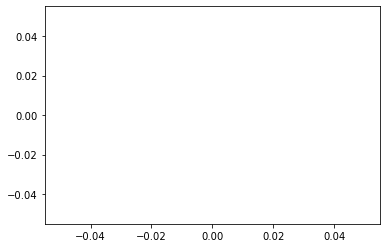

In [28]:
plt.scatter(sorted_df['marketingInvestment'], sorted_df['grossProfit'])

In [29]:
regr

array([-24910.84808962, -22927.71539662])

In [30]:
R = sorted_df['grossProfit'] - log_f(sorted_df['marketingInvestment'], *regr)

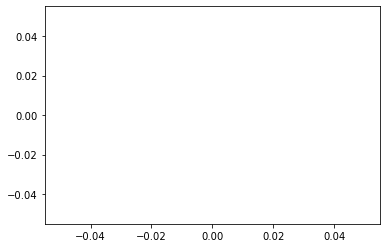

In [31]:
plt.scatter(sorted_df['marketingInvestment'], R)

In [32]:
R.describe()['std']

nan

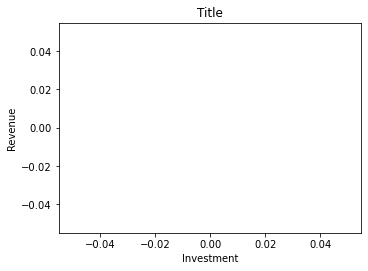

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.subplots_adjust(bottom=0.15, left=0.2)
x = np.linspace(0,sorted_df['marketingInvestment'].max(),20)
ax.scatter(sorted_df['marketingInvestment'], sorted_df['grossProfit'])
ax.plot(x,log_f(x, *regr))
ax.set_xlabel(f'Investment')
ax.set_ylabel(f'Revenue')
ax.set_title('Title')
#plt.savefig( name[0] + '.jpg', dpi=150, pad_inches=0.1)  
#plt.close()
plt.show()

In [34]:
sorted_df['netRevenue'].describe()[1]

nan

In [35]:
R.describe()[2]

nan

In [36]:
statistics_R2 = []

statistics_R2.append(np.concatenate((regr, err), axis=0))

statistics_R2_df = pd.DataFrame(statistics_R2, columns = regr_name)

statistics_R2_df = statistics_R2_df.set_index([pd.Index(platform_code)])

NameError: name 'regr_name' is not defined

In [ ]:
df_time_selected = df[df['periodStartDate'] >= df['periodStartDate'].max() - pd.DateOffset(weeks=time_window_regr)] 

df_business_selected = df_time_selected[df_time_selected['businessUnit'] == 'forhomecz']

df_business_selected = df_business_selected[df_business_selected['platformCode'] == 'AdWords']

ad_campaign_code = df['adCampaign'].unique().tolist()
#campaign_code.sort()

#campaign_code

## Collect regression parameters for individual Adds Campaign
### Collect all data for all clients into one file

In [37]:
excel_coll = 0
excel_row  = 2

In [38]:
workbook = xlsxwriter.Workbook('All cients all channels statistics.xlsx', 
                               {'nan_inf_to_errors': True})

worksheet = workbook.add_worksheet('channels')
bold = workbook.add_format({'bold': True})

excel_row

2

### Starts here

In [ ]:
df = pd.read_csv('input\\'+ list_files[0],
                 sep="\t",
                 infer_datetime_format=True,
                 usecols=usecols,
                 dtype=dtype,
                 parse_dates=DateTimeID)

df['periodStartDate'] = pd.to_datetime(df['periodStartDate'])

df.head(5)

In [ ]:
platform_code = df['platformCode'].unique().tolist()
platform_code.sort()
business_unit_code = df['businessUnit'].unique().tolist()
business_unit_code.sort()
channel_code_code = df['channelCode'].unique().tolist()
channel_code_code.sort()
currency_code_code = df['currencyCode'].unique().tolist()
currency_code_code.sort()
account_code = df['account'].unique().tolist()
#channel_code_code

In [19]:
#select window for regression 
#xcel_coll = 0

precision = 3

#workbook = xlsxwriter.Workbook(folder + account_code[0]+' Add campaign corr.xlsx', {'nan_inf_to_errors': True}) #folder + 

#bold = workbook.add_format({'bold': True})

#xlsxwriter.Workbook(path, {'strings_to_urls': False, 'nan_inf_to_errors': True}

df_time_selected = df[df['periodStartDate'] >= df['periodStartDate'].max() - pd.DateOffset(weeks=time_window_regr)] 

#df_time_selected = filter_df(df_time_selected, 0.1)



#excel_row  = 2

for i in business_unit_code:
    df_selected = df_time_selected[df_time_selected['businessUnit'] == i]
    #worksheet = workbook.add_worksheet(i)
    worksheet.set_column('A:A', 20)
    worksheet.set_column('B:B', 20)
    worksheet.set_column('C:C', 30)
    worksheet.set_column('D:D', 40)
    worksheet.set_column('E:E', 10)
    worksheet.set_column('F:F', 10)
    worksheet.set_column('G:G', 15)
    worksheet.set_column('H:H', 15)
    worksheet.set_column('I:I', 15)
    worksheet.set_column('J:J', 15)
    worksheet.set_column('K:K', 40)

    worksheet.write('A1', 'Client', bold)
    worksheet.write('B1', 'Business unit', bold)
    worksheet.write('C1', 'Platform', bold)
    worksheet.write('D1', 'Channel', bold)
    worksheet.write('E1', 'Corr coeff.', bold)
    worksheet.write('F1', 'Pr. value', bold)
    worksheet.write('G1', 'a', bold)
    worksheet.write('H1', 'b', bold)
    worksheet.write('I1', 'Mean', bold)
    worksheet.write('J1', 'R-std', bold)
    #worksheet.write('K1', 'Chart', bold)
    
    
    
    worksheet.write('A'+str(excel_row),i)
    
    for z in platform_code:
        df_platform = df_selected[df_selected['platformCode'] == z]
        
        ad_campaign_code = df_platform['adCampaign'].unique().tolist()
        
        for y in channel_code_code:
            
            df_platform = df_selected[df_selected['channelCode'] == y]
                
            df_business_selected_agg = select_agg_resample_df(df_platform, 'periodStartDate', 'week', use_nan = False)
            df_business_selected_agg = filter_df(df_business_selected_agg, 0.2)
            
        
            sper_crr, P_value = stat.spearmanr(df_business_selected_agg['marketingInvestment'],                       df_business_selected_agg['grossProfit'])
            if sper_crr> 0.9:
                print (y + ' Add campaign' + i + ' business unit '+ z + ' platform has \t'+ str(sper_crr) + ' corr coefficient')

                try:
                    sorted_df = df_business_selected_agg.sort_values( by=['marketingInvestment'], ascending=False )
                    t_train = sorted_df['marketingInvestment']
                    y_train = sorted_df['grossProfit']
                    
                    worksheet.write('A'+str(excel_row),account_code[0])
                    
                    worksheet.write('B'+str(excel_row), i)
                    
                    worksheet.write('C'+str(excel_row), z)
                    
                    worksheet.write('D'+str(excel_row), y)                    
                    
                    
                
                    regr, err = regression_calc(sorted_df[['marketingInvestment','grossProfit']],log_f)
                
                    R = sorted_df['grossProfit'] - log_f(sorted_df['marketingInvestment'], *regr)
                    R_std = R.describe()['std']
                    
                    Y_mean = sorted_df['grossProfit'].describe()[1]
                    
                    #ing_name = [y + i + z, currency_code_code]
                    #save_chart(sorted_df, ing_name, R_std)
                             
                    a,b = regr
                    #print(a,b,c)

                    
                    worksheet.write('E'+str(excel_row), str(np.round(sper_crr, precision)))
                    
                    worksheet.write('F'+str(excel_row), str(np.round(P_value, 7)))
                
                    worksheet.write('G'+str(excel_row), str(np.round(a, precision)))
                    
                    worksheet.write('H'+str(excel_row), str(np.round(b, precision)))                
                
                    worksheet.write('I'+str(excel_row), str(np.round(Y_mean, precision)))
                    
                    worksheet.write('J'+str(excel_row), str(np.round(R_std, precision)))
                
                    #worksheet.insert_image('K'+ str(excel_row), y + i + z + '.jpg', {'x_scale': 0.5, 'y_scale': 0.5})
                
                    #excel_row = excel_row + 1 # 10 for image included
                    #print('Regression calculated successfully')
                except:
                    print("Regression wasn't calculated")
                    # worksheet.write('A'+ str(excel_row), z)
                    #worksheet.write('A'+str(excel_row),account_code[0])
                    
                    #worksheet.write('B'+str(excel_row),i)
                    
                    #worksheet.write('C'+str(excel_row), z)
                    
                    #worksheet.write('D'+str(excel_row), y)
                    #excel_row = excel_row + 1
                    # excel_row = excel_row + 1
                excel_row = excel_row + 1

            else:
                worksheet.write('A'+str(excel_row),account_code[0])
                    
                worksheet.write('B'+str(excel_row),i)
                    
                worksheet.write('C'+str(excel_row), z)
                    
                worksheet.write('D'+str(excel_row), y)
                excel_row = excel_row + 1
                pass

#workbook.close()

Ads-DIS Add campaignforcampingcz business unit AdWords platform has 	0.9578947368421055 corr coefficient
Ads-PLA-PRO Add campaignforcampingcz business unit AdWords platform has 	0.967032967032967 corr coefficient
Ads-SEA-BRA Add campaignforcampingcz business unit AdWords platform has 	1.0 corr coefficient
Ads-SEA-GEN Add campaignforcampingcz business unit AdWords platform has 	0.9835164835164836 corr coefficient
Ads-SEA-PRO Add campaignforcampingcz business unit AdWords platform has 	0.9725274725274725 corr coefficient
Sklik-BRAND Add campaignforcampingcz business unit AdWords platform has 	0.9615384615384615 corr coefficient
Sklik-DIS Add campaignforcampingcz business unit AdWords platform has 	0.9615384615384615 corr coefficient
Sklik-PLA Add campaignforcampingcz business unit AdWords platform has 	0.9835164835164836 corr coefficient
Sklik-SEA-BRA Add campaignforcampingcz business unit AdWords platform has 	0.9065934065934067 corr coefficient
adform Add campaignforcampingcz business 

heureka Add campaignforcampingcz business unit HeurekaCz platform has 	0.9065934065934067 corr coefficient
Ads-DIS Add campaignforcampingcz business unit Sklik platform has 	0.9578947368421055 corr coefficient
Ads-PLA-PRO Add campaignforcampingcz business unit Sklik platform has 	0.967032967032967 corr coefficient
Ads-SEA-BRA Add campaignforcampingcz business unit Sklik platform has 	1.0 corr coefficient
Ads-SEA-GEN Add campaignforcampingcz business unit Sklik platform has 	0.9835164835164836 corr coefficient
Ads-SEA-PRO Add campaignforcampingcz business unit Sklik platform has 	0.9725274725274725 corr coefficient
Sklik-BRAND Add campaignforcampingcz business unit Sklik platform has 	0.9615384615384615 corr coefficient
Sklik-DIS Add campaignforcampingcz business unit Sklik platform has 	0.9615384615384615 corr coefficient
Sklik-PLA Add campaignforcampingcz business unit Sklik platform has 	0.9835164835164836 corr coefficient
Sklik-SEA-BRA Add campaignforcampingcz business unit Sklik pl

limit_output extension: Maximum message size of 10000 exceeded with 10059 characters

In [ ]:
workbook.close()

## Collect regression parameters for individual Platform

In [30]:
df = pd.read_csv('input\\'+ list_files[0],
                 sep="\t",
                 infer_datetime_format=True,
                 usecols=usecols,
                 dtype=dtype,
                 parse_dates=DateTimeID)

df['periodStartDate'] = pd.to_datetime(df['periodStartDate'])

df.head(5)

,account,businessUnit,platformCode,channelCode,adCampaign,marketingInvestment,impressions,clicks,visits,conversions,deliveries,netRevenue,grossProfit,currencyCode,adGroup,periodStartDate
0,forcamping,forcampingcz,unpaid,notset,NaN,0.0,0,0,0,5,5,10724.79,10724.79,CZK,-,2020-01-21
1,forcamping,forcampingcz,unpaid,direct,NaN,0.0,0,0,0,22,22,48687.03,48687.03,CZK,-,2020-01-21
2,forcamping,forcampingcz,HeurekaCz,heureka,NaN,0.0,0,0,51,2,2,3342.98,3342.98,CZK,-,2020-01-21
3,forcamping,forcampingcz,unpaid,organic,NaN,0.0,0,0,0,59,59,121605.97,121605.97,CZK,-,2020-01-21
4,forcamping,forcampingcz,ZboziCz,zbozi,NaN,0.0,0,0,83,3,3,3604.96,3604.96,CZK,-,2020-01-21


In [31]:
business_unit_code = df['businessUnit'].unique().tolist()
business_unit_code

['forcampingcz']

In [32]:
#select window for regression 
excel_coll = 0
precision  = 3
corr_thld  = 0.8
aws_alpha  = 0.15

platform_code = df['platformCode'].unique().tolist()
platform_code.sort()
business_unit_code = df['businessUnit'].unique().tolist()
business_unit_code.sort()
channel_code_code = df['channelCode'].unique().tolist()
channel_code_code.sort()
currency_code_code = df['currencyCode'].unique().tolist()
currency_code_code.sort()
account_code = df['account'].unique().tolist()


dropped_ch = ['Not tracked','notset','unpaid']

workbook = xlsxwriter.Workbook(folder + account_code[0]+' platform corr.xlsx') #folder + 

bold = workbook.add_format({'bold': True})

df_time_selected = df[df['periodStartDate'] >= df['periodStartDate'].max() - pd.DateOffset(weeks=time_window_regr)] 

worksheet = workbook.add_worksheet('Platform')

excel_row  = 2

output = pd.DataFrame()

for i in business_unit_code:
    df_selected = df_time_selected[df_time_selected['businessUnit'] == i]
    #worksheet = workbook.add_worksheet(i)
    worksheet.set_column('A:A', 20)
    worksheet.set_column('B:B', 20)
    worksheet.set_column('C:C', 30)
    worksheet.set_column('D:D', 10)
    worksheet.set_column('E:E', 10)
    worksheet.set_column('F:F', 10)
    worksheet.set_column('G:G', 15)
    worksheet.set_column('H:H', 15)
    worksheet.set_column('I:I', 15)
    worksheet.set_column('J:J', 15)
    worksheet.set_column('K:K', 15)
    worksheet.set_column('L:L', 15)

    worksheet.write('A1', 'Client', bold)
    worksheet.write('B1', 'Business unit', bold)
    worksheet.write('C1', 'Platform', bold)
    #worksheet.write('D1', 'Campaign', bold)
    worksheet.write('E1', 'Corr coeff.', bold)
    worksheet.write('F1', 'Pr. value', bold)
    worksheet.write('G1', 'a', bold)
    worksheet.write('H1', 'b', bold)
    worksheet.write('I1', 'Mean', bold)
    worksheet.write('J1', 'R-std', bold)
    worksheet.write('K1', 'Invest', bold)
    worksheet.write('L1', 'Profit', bold)
      
    worksheet.write('A'+str(excel_row),i)
    
    for z in platform_code:
        df_platform = df_selected[df_selected['platformCode'] == z]
                       
        df_business_selected_agg = select_agg_resample_df(df_platform, 'periodStartDate', 'week', use_nan = False)
        
        df_business_selected_agg_filter = filter_df(df_business_selected_agg, aws_alpha)
        
        # add dataframe for materialize interim results 
        
        temp_dict = dict([('Client',''),
                          ('Business unit',''),
                          ('Platform',''),
                          ('Corr coeff.', 0),
                          ('Pr. value', 0),
                          ('a',0),
                          ('b',0),
                          ('Mean',0),
                          ('R-std',0),
                          ('Invest',0),
                          ('Profit',0)])
        
        temp_dict['Client'] = account_code[0]
        temp_dict['Business unit'] = i
        temp_dict['Platform'] = z
        
        temp_dict['Profit'] = np.round(df_business_selected_agg['grossProfit'].sum(), 2)
        temp_dict['Invest'] = np.round(df_business_selected_agg['marketingInvestment'].sum(), 2)
        
        sper_crr, P_value = stat.spearmanr(df_business_selected_agg_filter['marketingInvestment'],                       df_business_selected_agg_filter['grossProfit'])
               
        if sper_crr> corr_thld:
            temp_dict['Corr coeff.'] = sper_crr
            temp_dict['Pr. value'] = P_value
            print (i + ' business unit '+ z + ' platform has \t'+ str(sper_crr) + ' corr coefficient')

            try:
                sorted_df = df_business_selected_agg_filter.sort_values( by=['marketingInvestment'], ascending=False )
                t_train = sorted_df['marketingInvestment']
                y_train = sorted_df['grossProfit']
                
                regr, err = regression_calc(sorted_df[['marketingInvestment','grossProfit']],log_f)
                
                R = sorted_df['grossProfit'] - log_f(sorted_df['marketingInvestment'], *regr)
                R_std = R.describe()['std']
                    
                Y_mean = sorted_df['grossProfit'].describe()[1]
                
                name = i + ' ' + z +' '
                ing_name = [name, currency_code_code]
                #save_chart(sorted_df, ing_name, R_std)
                             
                a,b = regr
                temp_dict['a'] = a
                temp_dict['b'] = b
                temp_dict['R-std'] = R_std
                temp_dict['Mean'] = Y_mean
                
                #print(a,b,c)
                worksheet.write('A'+str(excel_row), account_code[0])          
                worksheet.write('B'+str(excel_row), i) 
                worksheet.write('C'+str(excel_row), z)
                    
                #worksheet.write('D'+str(excel_row), y)                    
                worksheet.write('E'+str(excel_row), str(np.round(sper_crr, precision)))                    
                worksheet.write('F'+str(excel_row), str(np.round(P_value, 7)))             
                worksheet.write('G'+str(excel_row), str(np.round(a, precision)))                   
                worksheet.write('H'+str(excel_row), str(np.round(b, precision)))                                
                worksheet.write('I'+str(excel_row), str(np.round(Y_mean, precision)))                    
                worksheet.write('J'+str(excel_row), str(np.round(R_std, precision)))               
                worksheet.write('K'+str(excel_row), str(np.round(df_business_selected_agg['marketingInvestment'].sum(), 2)))        
                worksheet.write('L'+str(excel_row), str(np.round(df_business_selected_agg['grossProfit'].sum(), 2)))
                
                excel_row = excel_row + 1
                print('Regression calculated successfully')
            except:
                print("Regression wasn't calculated")
                # worksheet.write('A'+ str(excel_row), z)
                # excel_row = excel_row + 1
                worksheet.write('A'+str(excel_row),account_code[0])           
                worksheet.write('B'+str(excel_row), i)    
                worksheet.write('C'+str(excel_row), z) 
                worksheet.write('K'+str(excel_row), str(np.round(df_business_selected_agg['marketingInvestment'].sum(), 2)))
                worksheet.write('L'+str(excel_row), str(np.round(df_business_selected_agg['grossProfit'].sum(), 2)))
                
                temp_dict['a'] = 0
                temp_dict['b'] = 0
            
                excel_row = excel_row + 1

        else:
            worksheet.write('A'+str(excel_row), account_code[0])       
            worksheet.write('B'+str(excel_row), i)        
            worksheet.write('C'+str(excel_row), z)
            worksheet.write('K'+str(excel_row), str(np.round(df_business_selected_agg['marketingInvestment'].sum(), 2)))    
            worksheet.write('L'+str(excel_row), str(np.round(df_business_selected_agg['grossProfit'].sum(), 2)))
            
            excel_row = excel_row + 1
            
            temp_dict['a'] = 0
            temp_dict['b'] = 0
                        
        output = output.append(temp_dict, ignore_index=True)

worksheet = workbook.add_worksheet('Settings')

worksheet.set_column('A:A', 25)
worksheet.set_column('B:B', 15)
worksheet.set_column('C:C', 20)
worksheet.set_column('D:D', 20)
worksheet.set_column('E:E', 10)

worksheet.write('A1', 'Alpha (AWS filter coef.)', bold)
worksheet.write('B1', 'Corr. threshold', bold)
worksheet.write('C1', 'Time window [week]', bold)
worksheet.write('D1', 'Dropped channel.', bold)
#worksheet.write('E1', 'Corr coeff.', bold)

worksheet.write('A2',aws_alpha)
worksheet.write('B2',corr_thld)
worksheet.write('C2',time_window_regr)

for i in range(len(dropped_ch)):
    worksheet.write('D'+ str(i + 2), dropped_ch[i])

worksheet = workbook.add_worksheet('Summary')

worksheet.set_column('A:A', 15)
worksheet.set_column('B:B', 25)
worksheet.set_column('C:C', 25)
worksheet.set_column('D:D', 25)
worksheet.set_column('E:E', 25)
worksheet.set_column('F:F', 25)
worksheet.set_column('G:G', 25)
worksheet.set_column('H:H', 12)

worksheet.write('A1', 'Client', bold)
worksheet.write('B1', 'Investment under control', bold)
worksheet.write('C1', 'Non-controlled investment', bold)
worksheet.write('D1', 'Controlled investment, [%]', bold)
worksheet.write('E1', 'Profit under control', bold)
worksheet.write('F1', 'Non-controlled profit', bold)
worksheet.write('G1', 'Controlled profit, [%]', bold)
worksheet.write('H1', 'Level', bold)


filterd_out = output[~output['Platform'].isin(dropped_ch)]

corr_df = filterd_out[filterd_out['Corr coeff.'] > corr_thld]

non_corr_df = filterd_out[filterd_out['Corr coeff.'] <= corr_thld]

control_inv = corr_df['Invest'].sum()

non_control_inv = non_corr_df['Invest'].sum()

control_prof = corr_df['Profit'].sum()

non_control_iprof = non_corr_df['Profit'].sum()

worksheet.write('A2',account_code[0])
worksheet.write('B2',control_inv)
worksheet.write('C2',non_control_inv)
worksheet.write('D2',str(np.round((control_inv/(non_control_inv + control_inv))*100, 1)))
worksheet.write('E2',control_prof)
worksheet.write('F2',non_control_iprof)
worksheet.write('G2',str(np.round((control_prof/(non_control_iprof + control_prof))*100, 1)))
worksheet.write('H2', 'Platform', bold)

workbook.close()

forcampingcz business unit AdWords platform has 	0.8571428571428571 corr coefficient
Regression calculated successfully
forcampingcz business unit Adform platform has 	0.9081660805438483 corr coefficient
Regression calculated successfully
forcampingcz business unit CjAffiliate platform has 	0.825188065671118 corr coefficient
Regression calculated successfully
forcampingcz business unit Criteo platform has 	0.8571428571428571 corr coefficient
Regression calculated successfully
forcampingcz business unit HeurekaCz platform has 	0.9780219780219779 corr coefficient
Regression calculated successfully
forcampingcz business unit Sklik platform has 	0.901098901098901 corr coefficient
Regression calculated successfully
forcampingcz business unit ZboziCz platform has 	0.9285714285714285 corr coefficient
Regression calculated successfully


In [34]:
filterd_out

,Business unit,Client,Corr coeff.,Invest,Mean,Platform,Pr. value,Profit,R-std,a,b
0,forcampingcz,forcamping,0.857143,2498886.33,1.347713e+06,AdWords,1.809341e-04,24723808.49,127506.490168,-3.522408e+10,-3.525688e+09
1,forcampingcz,forcamping,0.908166,141055.05,6.057012e+02,Adform,1.763031e-05,11858.65,145.862185,2.706003e+06,3.204112e+07
2,forcampingcz,forcamping,0.825188,129781.24,1.742531e+05,CjAffiliate,5.147121e-04,3336740.70,56797.853131,2.237580e+05,4.842359e+02
3,forcampingcz,forcamping,0.857143,72745.85,7.748536e+04,Criteo,1.809341e-04,1255595.11,3495.615452,1.394357e+05,5.112210e+03
4,forcampingcz,forcamping,0.000000,599074.98,0.000000e+00,FacebookBusinessAdsManager,0.000000e+00,1064498.45,0.000000,0.000000e+00,0.000000e+00
5,forcampingcz,forcamping,0.000000,11584.09,0.000000e+00,Favi,0.000000e+00,75762.98,0.000000,0.000000e+00,0.000000e+00
6,forcampingcz,forcamping,0.978022,253309.52,4.431343e+05,HeurekaCz,7.757814e-09,8828597.69,43520.632068,1.247685e+06,2.549573e+04
7,forcampingcz,forcamping,0.901099,447646.55,1.936951e+05,Sklik,2.613862e-05,4013801.63,20717.569022,-7.292164e+09,-8.616597e+08
8,forcampingcz,forcamping,0.928571,38701.50,1.484100e+05,ZboziCz,4.607427e-06,2860389.32,11529.378777,-5.495873e+05,-8.500254e+03


## Collect regression parameters for individual Campaign

In [27]:
df = pd.read_csv('input\\'+ list_files[33],
                 sep="\t",
                 infer_datetime_format=True,
                 usecols=usecols,
                 dtype=dtype,
                 parse_dates=DateTimeID)

df['periodStartDate'] = pd.to_datetime(df['periodStartDate'])

df.head(5)

,account,businessUnit,platformCode,channelCode,adCampaign,marketingInvestment,impressions,clicks,visits,conversions,deliveries,netRevenue,grossProfit,currencyCode,adGroup,periodStartDate
0,vodafoneczechrepublicas,vodafonecz-leady,unpaid,notset,NaN,0.0,0,0,0,0,0,0.0,0.0,CZK,-,2020-01-23
1,vodafoneczechrepublicas,vodafonecz-leady,unpaid,direct,NaN,0.0,0,0,0,11,11,0.0,0.0,CZK,-,2020-01-23
2,vodafoneczechrepublicas,vodafonecz-leady,unpaid,email,NaN,0.0,0,0,0,0,0,0.0,0.0,CZK,-,2020-01-23
3,vodafoneczechrepublicas,vodafonecz-leady,unpaid,internal,NaN,0.0,0,0,0,0,0,0.0,0.0,CZK,-,2020-01-23
4,vodafoneczechrepublicas,vodafonecz-leady,AdWords,naturalsearch-google,NaN,0.0,0,0,18864,8,8,0.0,0.0,CZK,-,2020-01-23


In [ ]:
#select window for regression 
excel_coll = 0
precision  = 3
corr_thld  = 0.8
aws_alpha  = 0.15

platform_code = df['platformCode'].unique().tolist()
platform_code.sort()
business_unit_code = df['businessUnit'].unique().tolist()
business_unit_code.sort()
channel_code_code = df['channelCode'].unique().tolist()
channel_code_code.sort()
currency_code_code = df['currencyCode'].unique().tolist()
currency_code_code.sort()
account_code = df['account'].unique().tolist()


dropped_ch = ['Not tracked','notset','unpaid']

workbook = xlsxwriter.Workbook(folder + account_code[0]+' Campaign corr.xlsx',  {'nan_inf_to_errors': True}) #folder + 

bold = workbook.add_format({'bold': True})

df_time_selected = df[df['periodStartDate'] >= df['periodStartDate'].max() - pd.DateOffset(weeks=time_window_regr)] 

worksheet = workbook.add_worksheet('Platform')

excel_row  = 2

output = pd.DataFrame()

for i in business_unit_code:
    df_selected = df_time_selected[df_time_selected['businessUnit'] == i]
    #worksheet = workbook.add_worksheet(i)
    worksheet.set_column('A:A', 20)
    worksheet.set_column('B:B', 20)
    worksheet.set_column('C:C', 30)
    worksheet.set_column('D:D', 10)
    worksheet.set_column('E:E', 10)
    worksheet.set_column('F:F', 10)
    worksheet.set_column('G:G', 15)
    worksheet.set_column('H:H', 15)
    worksheet.set_column('I:I', 15)
    worksheet.set_column('J:J', 15)
    worksheet.set_column('K:K', 15)
    worksheet.set_column('L:L', 15)

    worksheet.write('A1', 'Client', bold)
    worksheet.write('B1', 'Business unit', bold)
    worksheet.write('C1', 'Campaign', bold)
    #worksheet.write('D1', 'Campaign', bold)
    worksheet.write('E1', 'Corr coeff.', bold)
    worksheet.write('F1', 'Pr. value', bold)
    worksheet.write('G1', 'a', bold)
    worksheet.write('H1', 'b', bold)
    worksheet.write('I1', 'Mean', bold)
    worksheet.write('J1', 'R-std', bold)
    worksheet.write('K1', 'Invest', bold)
    worksheet.write('L1', 'Profit', bold)
      
    worksheet.write('A'+str(excel_row),i)
    
    campaign_code = df['adCampaign'].unique().tolist()
    #campaign_code.sort()
    
    for z in campaign_code:
        df_platform = df_selected[df_selected['adCampaign'] == z]
                       
        df_business_selected_agg = select_agg_resample_df(df_platform, 'periodStartDate', 'week', use_nan = False)
        
        df_business_selected_agg_filter = filter_df(df_business_selected_agg, aws_alpha)
        
        # add dataframe for materialize interim results 
        
        temp_dict = dict([('Client',''),
                          ('Business unit',''),
                          ('Campaign',''),
                          ('Corr coeff.', 0),
                          ('Pr. value', 0),
                          ('a',0),
                          ('b',0),
                          ('Mean',0),
                          ('R-std',0),
                          ('Invest',0),
                          ('Profit',0)])
        
        temp_dict['Client'] = account_code[0]
        temp_dict['Business unit'] = i
        temp_dict['Platform'] = z
        
        temp_dict['Profit'] = np.round(df_business_selected_agg['grossProfit'].sum(), 2)
        temp_dict['Invest'] = np.round(df_business_selected_agg['marketingInvestment'].sum(), 2)
        
        sper_crr, P_value = stat.spearmanr(df_business_selected_agg_filter['marketingInvestment'],                       df_business_selected_agg_filter['grossProfit'])
               
        if sper_crr> corr_thld:
            temp_dict['Corr coeff.'] = sper_crr
            temp_dict['Pr. value'] = P_value
            print (i + ' business unit '+ z + ' platform has \t'+ str(sper_crr) + ' corr coefficient')

            try:
                sorted_df = df_business_selected_agg_filter.sort_values( by=['marketingInvestment'], ascending=False )
                t_train = sorted_df['marketingInvestment']
                y_train = sorted_df['grossProfit']       
                regr, err = regression_calc(sorted_df[['marketingInvestment','grossProfit']],log_f)               
                R = sorted_df['grossProfit'] - log_f(sorted_df['marketingInvestment'], *regr)
                R_std = R.describe()['std']    
                Y_mean = sorted_df['grossProfit'].describe()[1]
                name = i + ' ' + z +' '
                
                ing_name = [name, currency_code_code]
                #save_chart(sorted_df, ing_name, R_std)
                             
                a,b = regr
                temp_dict['a'] = a
                temp_dict['b'] = b
                temp_dict['R-std'] = R_std
                temp_dict['Mean'] = Y_mean
                
                #print(a,b,c)
                worksheet.write('A'+str(excel_row), account_code[0])          
                worksheet.write('B'+str(excel_row), i) 
                worksheet.write('C'+str(excel_row), z)
                    
                #worksheet.write('D'+str(excel_row), y)                    
                worksheet.write('E'+str(excel_row), str(np.round(sper_crr, precision)))                    
                worksheet.write('F'+str(excel_row), str(np.round(P_value, 7)))             
                worksheet.write('G'+str(excel_row), str(np.round(a, precision)))                   
                worksheet.write('H'+str(excel_row), str(np.round(b, precision)))                                
                worksheet.write('I'+str(excel_row), str(np.round(Y_mean, precision)))                    
                worksheet.write('J'+str(excel_row), str(np.round(R_std, precision)))               
                worksheet.write('K'+str(excel_row), str(np.round(df_business_selected_agg['marketingInvestment'].sum(), 2)))        
                worksheet.write('L'+str(excel_row), str(np.round(df_business_selected_agg['grossProfit'].sum(), 2)))
                
                excel_row = excel_row + 1
                print('Regression calculated successfully')
            except:
                print("Regression wasn't calculated")
                # worksheet.write('A'+ str(excel_row), z)
                # excel_row = excel_row + 1
                worksheet.write('A'+str(excel_row),account_code[0])           
                worksheet.write('B'+str(excel_row), i)    
                worksheet.write('C'+str(excel_row), z) 
                worksheet.write('K'+str(excel_row), str(np.round(df_business_selected_agg['marketingInvestment'].sum(), 2)))
                worksheet.write('L'+str(excel_row), str(np.round(df_business_selected_agg['grossProfit'].sum(), 2)))
                
                temp_dict['a'] = 0
                temp_dict['b'] = 0
            
                excel_row = excel_row + 1

        else:
            worksheet.write('A'+str(excel_row), account_code[0])       
            worksheet.write('B'+str(excel_row), i)        
            worksheet.write('C'+str(excel_row), z)
            worksheet.write('K'+str(excel_row), str(np.round(df_business_selected_agg['marketingInvestment'].sum(), 2)))    
            worksheet.write('L'+str(excel_row), str(np.round(df_business_selected_agg['grossProfit'].sum(), 2)))
            
            excel_row = excel_row + 1
            
            temp_dict['a'] = 0
            temp_dict['b'] = 0
                        
        output = output.append(temp_dict, ignore_index=True)

worksheet = workbook.add_worksheet('Settings')

worksheet.set_column('A:A', 25)
worksheet.set_column('B:B', 15)
worksheet.set_column('C:C', 20)
worksheet.set_column('D:D', 20)
worksheet.set_column('E:E', 10)

worksheet.write('A1', 'Alpha (AWS filter coef.)', bold)
worksheet.write('B1', 'Corr. threshold', bold)
worksheet.write('C1', 'Time window [week]', bold)
worksheet.write('D1', 'Dropped channel.', bold)
#worksheet.write('E1', 'Corr coeff.', bold)

worksheet.write('A2',aws_alpha)
worksheet.write('B2',corr_thld)
worksheet.write('C2',time_window_regr)

for i in range(len(dropped_ch)):
    worksheet.write('D'+ str(i + 2), dropped_ch[i])

worksheet = workbook.add_worksheet('Summary')

worksheet.set_column('A:A', 15)
worksheet.set_column('B:B', 25)
worksheet.set_column('C:C', 25)
worksheet.set_column('D:D', 25)
worksheet.set_column('E:E', 25)
worksheet.set_column('F:F', 25)
worksheet.set_column('G:G', 25)
worksheet.set_column('H:H', 12)

worksheet.write('A1', 'Client', bold)
worksheet.write('B1', 'Investment under control', bold)
worksheet.write('C1', 'Non-controlled investment', bold)
worksheet.write('D1', 'Controlled investment, [%]', bold)
worksheet.write('E1', 'Profit under control', bold)
worksheet.write('F1', 'Non-controlled profit', bold)
worksheet.write('G1', 'Controlled profit, [%]', bold)
worksheet.write('H1', 'Level', bold)


filterd_out = output[~output['Platform'].isin(dropped_ch)]

corr_df = filterd_out[filterd_out['Corr coeff.'] > corr_thld]

non_corr_df = filterd_out[filterd_out['Corr coeff.'] <= corr_thld]

control_inv = corr_df['Invest'].sum()

non_control_inv = non_corr_df['Invest'].sum()

control_prof = corr_df['Profit'].sum()

non_control_iprof = non_corr_df['Profit'].sum()

worksheet.write('A2',account_code[0])
worksheet.write('B2',control_inv)
worksheet.write('C2',non_control_inv)
worksheet.write('D2',str(np.round((control_inv/(non_control_inv + control_inv))*100, 1)))
worksheet.write('E2',control_prof)
worksheet.write('F2',non_control_iprof)
worksheet.write('G2',str(np.round((control_prof/(non_control_iprof + control_prof))*100, 1)))
worksheet.write('H2', 'Platform', bold)

workbook.close()

In [ ]:
writer = pd.ExcelWriter('pandas_simple.xlsx', engine='xlsxwriter')

In [ ]:
filterd_out = output[~output['Platform'].isin(dropped_ch)]
filterd_out = filterd_out.reset_index()

In [ ]:
filterd_out.to_excel(writer, sheet_name='Sheet1')
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

worksheet.set_column('A:A', 20)
worksheet.set_column('B:B', 20)
worksheet.set_column('C:C', 20)
worksheet.set_column('D:D', 20)
worksheet.set_column('E:E', 20)
worksheet.set_column('F:F', 20)
worksheet.set_column('G:G', 20)
worksheet.set_column('H:H', 20)
worksheet.set_column('I:I', 20)
worksheet.set_column('J:J', 20)
worksheet.set_column('K:K', 20)
worksheet.set_column('L:L', 20)

filterd_out.to_excel(writer, sheet_name='Sheet2')
workbook  = writer.book
worksheet = writer.sheets['Sheet2']

worksheet.set_column('A:A', 20)
worksheet.set_column('B:B', 20)
worksheet.set_column('C:C', 20)
worksheet.set_column('D:D', 20)
worksheet.set_column('E:E', 20)
worksheet.set_column('F:F', 20)
worksheet.set_column('G:G', 20)
worksheet.set_column('H:H', 20)
worksheet.set_column('I:I', 20)
worksheet.set_column('J:J', 20)
worksheet.set_column('K:K', 20)
worksheet.set_column('L:L', 20)

In [ ]:
#corr_df = filterd_out[filterd_out['Corr coeff.'] > corr_thld]
#corr_df

In [ ]:
corr_df['Invest'].sum()

In [ ]:
#non_corr_df = filterd_out[filterd_out['Corr coeff.'] <= corr_thld]
#non_corr_df

In [ ]:
non_corr_df['Invest'].sum()

In [ ]:
workbook.close()

In [ ]:
output.tail()

In [ ]:
#filterd_out = output[~output['Platform'].isin(dropped_ch)]

In [ ]:
#filterd_out.reset_index().tail(20)

In [ ]:
#filterd_out['Platform'].unique().tolist()

In [ ]:
filterd_bad = output[output['Platform'].isin(dropped_ch)]
#filterd_bad

In [ ]:
dropped_ch